   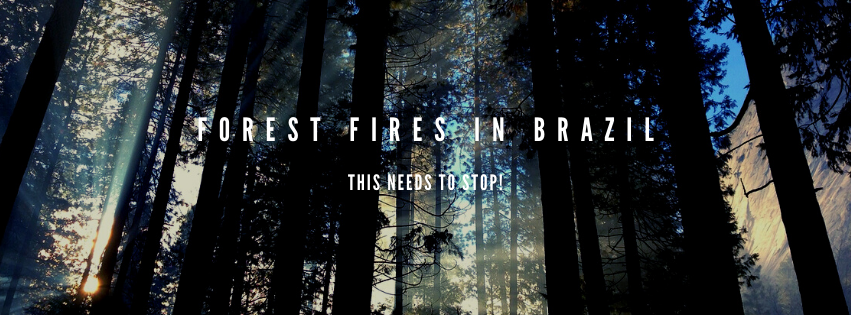

In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import pandasql as psql
sql=psql.sqldf
import numpy as np
sns.set_style("dark")
!pip install sidetable
import sidetable


# Data Import
df = pd.read_csv('../input/forest-fires-in-brazil/amazon.csv', encoding='latin1')
df.head(5)

**Context**

Forest fires are a serious problem for the preservation of the Tropical Forests. Understanding the frequency of forest fires in a time series can help to take action to prevent them. Brazil has the largest rainforest on the planet that is the Amazon rainforest. I'm personally affected by this because I'm Brazilian and I come from one of most touched areas by this fire (North)

**Content**

This dataset report of the number of forest fires in Brazil divided by states. The series comprises the period of approximately 10 years (1998 to 2017). The data were obtained from the official website of the Brazilian government.

http://dados.gov.br/dataset/sistema-nacional-de-informacoes-florestais-snif

# 1. Checking Data & Feature Eng

In [ ]:
#Just renaming the number columns
df.rename(columns={'number':'number_fires'},inplace=True)

#Getting the columns into a list
colunas=df.columns.to_list()

#It was messing up my charts :D so I converted to string - but you should use pd.datetime for sure!
df['year']=df['year'].astype(str)

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

missing=missing_data(df)


print(colunas)
print(missing)

No missing data!

In [ ]:
#Mapping states by region 
df['state'].unique()

state_region={'Acre':'North', 'Alagoas':'Northeast', 'Amapa':'North', 'Amazonas':'North', 'Bahia':'Northeast', 'Ceara':'Northeast',
       'Distrito Federal':'Midwest', 'Espirito Santo':'Southeast', 'Goias':'Midwest', 'Maranhao':'Northeast',
       'Mato Grosso':'Midwest', 'Minas Gerais':'Southeast', 'Pará':'North', 'Paraiba':'Northeast', 'Pernambuco':'Northeast',
       'Piau':'Northeast', 'Rio':'Southeast', 'Rondonia':'North', 'Roraima':'North', 'Santa Catarina':'South',
       'Sao Paulo':'Southeast', 'Sergipe':'Northeast', 'Tocantins':'North'}
df['region']=df['state'].map(state_region)

#Ordering Months
month_order={'Janeiro':'01', 'Fevereiro':'02', 'Março':'03', 'Abril':'04', 'Maio':'05', 'Junho':'06', 'Julho':'07',
       'Agosto':'08', 'Setembro':'09', 'Outubro':'10', 'Novembro':'11', 'Dezembro':'12'}
df['month_order']=df['month'].map(month_order)

Brazil is a very large country with a lot differences across regions. For ex. Northern region is the poorest (where I come from..) and Southeast is the economic hub of the country. That's why I want to differentiate them.

# 2. Analysis by Region

In [ ]:
#Using Sidetable to check how data is distributed.

df.stb.freq(['region'],style=True)

Northeast and North Region contains more rows within our dataset. Does this reflects also in number of fires?

In [ ]:
#Now that we have this information lets see how many fires by region and state.

fires_by_region=sql('''select region, round(sum(number_fires)) as number_fires, round(avg(number_fires)) as average_fires from df
             group by region
             order by number_fires desc''')   



print(fires_by_region)


So..Yes. Northeast and North region have more fires.

For those who don't know Brazil regions - here a map - I come from the North - State of Pará (Hi Mom!)


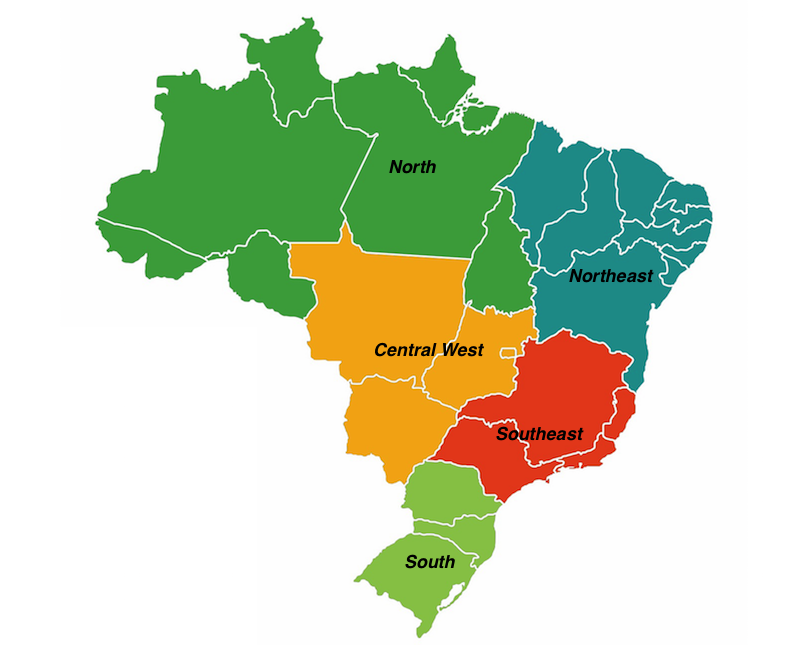

In [ ]:
#Lets see the distribution by state & Region Now - And Take Only TOP 10

#Using a little bit of SQL because Why Not?
fires_by_regionandstate=sql('''select region,state,round(sum(number_fires)) as number_fires from df
                          group by region,state
                          order by number_fires desc
                          limit 10''')
print(fires_by_regionandstate)

We can clearly see that even though **Midwest is in the 4th position in the fires ranking, one state from there has the highest amount of fires**.

Mato Grosso has a very dry weather but to be honest what has caused this is the influence of the **agricultural lobby that exists in Brazil**. **The Maggi Family** (Maggi Products) is very powerful there and one of them was even the governor for a while..

In [ ]:
#Let's check the fires trend by region & year


#Coming back to Pandas because Why Not?

evolutionbyregion=df.groupby(['year','region']).sum().sort_values('year',ascending=True).unstack().fillna(0)         

evolutionbyregion.plot(kind='bar',stacked=True,figsize=(25,9),colormap='Accent')
plt.title('Evolution of Fires by Region', fontsize = 25)
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Number of Fires', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(['Midwest','North','Northeast','South','Southeast'],bbox_to_anchor=(1, 0.5))


Looking quickly, it doesn't look like the distribution between the regions have changed from 1998-2017. **North and Northeast** are almost always on top in basically every year.

Funny enough, during **2008 financial crisis** the number of fires were lower than some previous and future years...I guess there were not enough money to finance some fires..

In [ ]:
#Let's see how it is the trend per month


#Sum of all the years



forchartline=df.groupby(['year','region']).sum().sort_values('year',ascending=True).reset_index()
c=sns.relplot(x="year", y="number_fires",
                 col="region",
                 kind="line", data=forchartline)
c.set_xticklabels(rotation=90)

forchartlinemonth=sql('''select region, month_order, sum(number_fires) as number_fires from df
                      group by region,month_order
                      order by month''')
                      
                                    
g=sns.relplot(x='month_order',y='number_fires',col='region',kind='line',data=forchartlinemonth)
g.set_xticklabels(rotation=90)

Year - Trend doesn't look so good for the us...

Month - The peak almost always happen mid-year - FYI in Brazil we different seasons by hemisphere

For ex - mid-year is Summer in North but Winter in South

# 3. Analysis by Goverment - Left or Right

Maybe you are not aware, but Brazil is completely divided into Left and Right Wing Parties. The discussions are fierce and every side tries to blame the other for every bad thing that happen to our country.

If you want to know more I advise you to search on google the terms Bolsonaro and Lula. Prepare some popcorn before you start it.

I have my opinion (that's why is biased..duu) and I want to check if my assumptions are correct. Let's go!

In [ ]:
#We need to identify which party was on power during the period we have available.

party_of_president={'1998':'PSDB', '1999':'PSDB', '2000':'PSDB', '2001':'PSDB', '2002':'PSDB', '2003':'PT', '2004':'PT', '2005':'PT',
       '2006':'PT', '2007':'PT', '2008':'PT', '2009':'PT', '2010':'PT', '2011':'PT', '2012':'PT', '2013':'PT',
       '2014':'PT', '2015':'PT', '2016':'PT', '2017':'PMDB'}

president={'1998':'FHC', '1999':'FHC', '2000':'FHC', '2001':'FHC', '2002':'Lula', '2003':'Lula', '2004':'Lula', '2005':'Lula',
       '2006':'Lula', '2007':'Lula', '2008':'Lula', '2009':'Lula', '2010':'Lula', '2011':'Dilma', '2012':'Dilma', '2013':'Dilma',
       '2014':'Dilma', '2015':'Dilma', '2016':'Dilma', '2017':'Temer'}

df['party']=df['year'].map(party_of_president)
df['president']=df['year'].map(president)

print(df.head(1))


In [ ]:
party_year=df.groupby(['year','party','president']).mean().reset_index()

chart = sns.catplot(x="year", y="number_fires",
                hue="president",kind='bar',
                data=party_year,aspect=3)
plt.title('Average Number of Fires by Year and President', fontsize = 25)


To be fair the analysis is not completely fair since PT (Left Wing) stayed in power from 2002 to 2016. However using the data that we have we conclude that the left wing didn't do their job and secured our beloved forest.


Let's do the same exercise and identify who was in power in the State placed in Rank 1 - Mato Grosso

In [ ]:
#filtering our data to have only Mato Grosso
mt=df[df['state']=='Mato Grosso']

partidos={'1998':'PSDB', '1999':'PSDB', '2000':'PSDB', '2001':'PSDB', '2002':'PSDB', '2003':'Cidadania/Maggi', '2004':'Cidadania/Maggi', '2005':'Cidadania/Maggi',
       '2006':'Cidadania/Maggi', '2007':'Cidadania/Maggi', '2008':'Cidadania/Maggi', '2009':'Cidadania/Maggi', '2010':'PMDB', '2011':'PMDB', '2012':'PMDB', '2013':'PMDB',
       '2014':'PMDB', '2015':'PSDB', '2016':'PSDB', '2017':'PSDB'}

mt['party_state']=mt['year'].map(partidos)


FYI - The only party that could be considered left on this list is the Cidadania which was called (PPS - Partido Popular Socialista) since they are currently opposed to Bolsonaro (extreme right) - However, as written above, during that time Cidadania Governor was Blairo Maggi which is a Billionare (agriculture lobby..)

In [ ]:
party_year_state=mt.groupby(['year','party_state']).mean().reset_index()

chart2 = sns.catplot(x="year", y="number_fires",
                hue="party_state",kind='bar',
                data=party_year_state,aspect=3)
plt.title('Average Number of Fires by Year and Party in Mato Grosso', fontsize = 25)

:) Draw your own conclusions here :)

# Quick & Simple dataviz using Tableau
https://public.tableau.com/views/BrazilWildfires/Dashboard1?:display_count=y&publish=yes&:origin=viz_share_link

**If you liked this notebook, please leave an upvote to support my work :)**

<div class='tableauPlaceholder' id='viz1592068842149' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Br&#47;BrazilWildfires&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='BrazilWildfires&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Br&#47;BrazilWildfires&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1592068842149');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='600px';vizElement.style.height='927px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='600px';vizElement.style.height='927px';} else { vizElement.style.width='100%';vizElement.style.height='977px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

# Sources
https://pt.wikipedia.org/wiki/Cidadania_(partido_pol%C3%ADtico)

https://veja.abril.com.br/politica/pps-tira-socialista-do-nome-e-passa-a-se-chamar-cidadania/

https://pt.wikipedia.org/wiki/Lista_de_presidentes_do_Brasil